### Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Data Preparation

Here we prepared all data related for the CNN, for example importing libraries, dataset, etc

### Importing all the important libraries

In [1]:
# We import all the needed libraries for the CNN algorithm

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-07-12 21:05:06.458020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing Skin Cancer Data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [1]:
# We stored the dataset source in Google Drive. So this below syntax was intended to read directory in user GDrive

#from google.colab import drive

#drive.mount('/content/gdrive/', force_remount=True)

# Above code is not needed since I am running the code in local machine

In [2]:
# Defining the path for train and test images (all the files are stored in GDrive )

data_dir_train=pathlib.Path('/Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test=pathlib.Path('/Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)



2239
118


### Create a dataset

Here, we defined the dataset to be proceeded in the next steps

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2023-07-12 21:05:38.822821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), 
                                                               seed=123,subset="validation",
                                                               validation_split=0.2)



Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print('Total Classes',len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Classes 9


In [8]:
#total all files directories
len(train_ds.file_paths)

1792

## Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

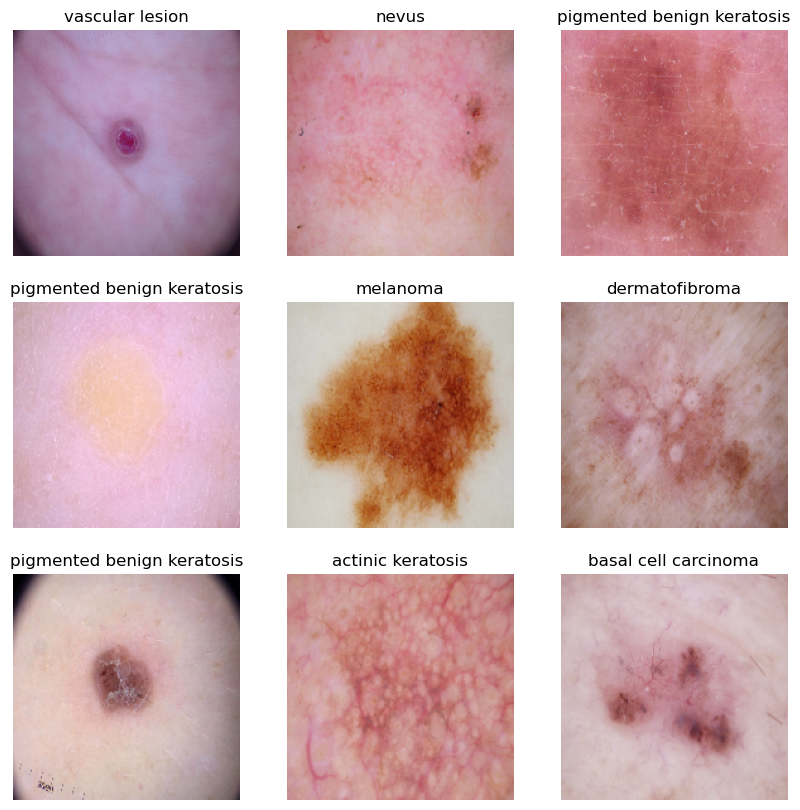

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
#Since we have created DataFrame for the directory and class name, here we show the table
dat_f.head()

,class_name,directory,file_name
0,actinic keratosis,/Users/prampras/Desktop/My_Desktop/ST/Upgrad_A...,ISIC_0029460.jpg
1,actinic keratosis,/Users/prampras/Desktop/My_Desktop/ST/Upgrad_A...,ISIC_0031993.jpg
2,actinic keratosis,/Users/prampras/Desktop/My_Desktop/ST/Upgrad_A...,ISIC_0029500.jpg
3,actinic keratosis,/Users/prampras/Desktop/My_Desktop/ST/Upgrad_A...,ISIC_0026626.jpg
4,actinic keratosis,/Users/prampras/Desktop/My_Desktop/ST/Upgrad_A...,ISIC_0032135.jpg


In [14]:
# From below code we can see an imbalanced class and Pigmented and Melanoma are the highest ones
print('Number of Cases by Class Name')
dat_f.groupby('class_name')['file_name'].count().sort_values(ascending = False)

Number of Cases by Class Name


class_name
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
actinic keratosis             228
squamous cell carcinoma       181
vascular lesion               139
dermatofibroma                 95
seborrheic keratosis           77
Name: file_name, dtype: int64

In [15]:
# As per below contribution, Pigmented Benign Keratosis and Melanoma have contributed almoost ~40% of population
print('Contribution of Cases by Class Name')
dat_f.groupby('class_name')['file_name'].count().sort_values(ascending = False)/dat_f['file_name'].count()

Contribution of Cases by Class Name


class_name
pigmented benign keratosis    0.196345
melanoma                      0.186145
basal cell carcinoma          0.159796
nevus                         0.151721
actinic keratosis             0.096898
squamous cell carcinoma       0.076923
vascular lesion               0.059074
dermatofibroma                0.040374
seborrheic keratosis          0.032724
Name: file_name, dtype: float64

In [16]:
new_dat = pd.DataFrame(dat_f.groupby('class_name')['file_name'].count().sort_values(ascending = False)/dat_f['file_name'].count())
new_dat = new_dat.rename(columns={'class_name': 'class_name', 'file_name': 'contribution_pct'})
new_dat = new_dat.reset_index()

<Axes: xlabel='class_name', ylabel='contribution_pct'>

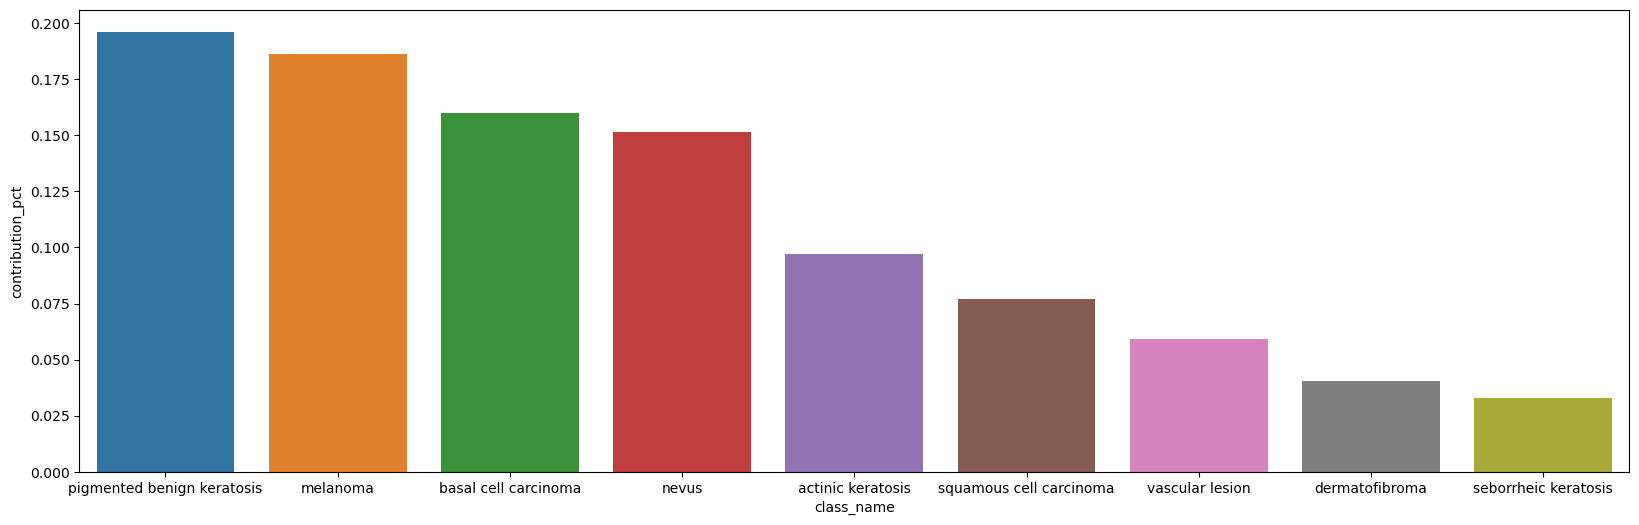

In [17]:
# Below is the visualization of the skin disease contribution
import seaborn as sns
plt.figure(figsize=(20, 6))
sns.barplot(x="class_name", y="contribution_pct", data=new_dat)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Development (First Iteration)
#### Here we created which can accurately detect 9 classes present in the dataset. We also normalized the pixel value

### Create The CNN Model

In [19]:
# In summary, for the first trial, we used 3 Convulation layer with pooling (2,3). We didnt use dropouts or regularization in the first trial.
# The activation function that we used is RelU and Softmax at the end because it's a classification problem.

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(64,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

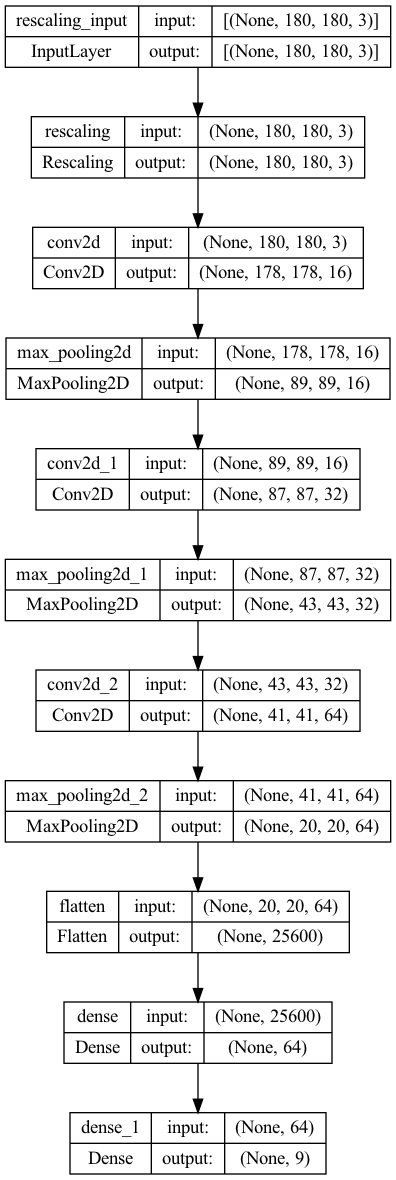

In [20]:
# Below, we showed the overall/summary of our CNN architecture based on the model hyperparameter we defined above
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [21]:
#Adam optimization: is a stochastic gradient descent method
#categorical_crossentropy: It's a loss function for multi-class classification model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### Train the model

In [22]:
# In this first trial, we run based on 20 epochs and concluded the result
epochs = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 28s 378ms/step - loss: 1.9880 - accuracy: 0.2634 - val_loss: 1.7830 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 18s 326ms/step - loss: 1.6234 - accuracy: 0.4464 - val_loss: 1.5158 - val_accuracy: 0.5123
Epoch 3/20
56/56 [==============================] - 19s 341ms/step - loss: 1.5207 - accuracy: 0.4766 - val_loss: 1.5216 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 21s 374ms/step - loss: 1.3691 - accuracy: 0.5117 - val_loss: 1.3765 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 21s 380ms/step - loss: 1.2868 - accuracy: 0.5463 - val_loss: 1.4259 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 21s 372ms/step - loss: 1.2501 - accuracy: 0.5603 - val_loss: 1.4023 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 19s 338ms/step - loss: 1.1332 - accuracy: 0.5921 - val_loss: 1.4121 - val_accuracy: 0.5302

From the result above, we can see that the accuracy is pretty high 0.94, but the gap with validation accuracy is quite high (0nly 0.8). Therefore, here we suspected there's overfitting

### Visualizing training results

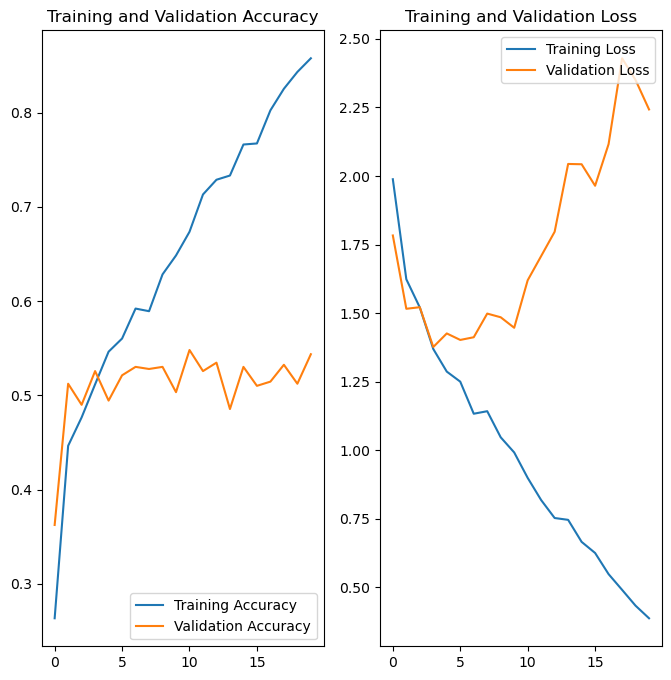

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# From the visualization below, at first the accuracy of training and validation are increasing together in the first epochs
# But as the epochs increased, the accuracy for validation increased slowly. This was the case of overfitting

### Findings


From the visualization below, at first the accuracy of training and validation are increasing together in the first epochs
But as the epochs increased, the accuracy for validation increased slowly. This was the case of overfitting

### Proposed Solution



*   We tried to use dropouts first as part of regularization
*   We tried to combine with Augmentor library too



## Model Development (Second Iteration)


In [24]:
# As the first solution, we used dropout first. Other hyperparamaters are the same
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())


#Dense Layer
model.add(layers.Dense(64,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                  

### Compiling the model

In [25]:
# Compiling the model with the same logic and condition as above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### Training the model

We trained the model with the new CNN arch (added Dropout)

In [26]:


epochs = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 21s 368ms/step - loss: 2.1777 - accuracy: 0.1903 - val_loss: 2.0751 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 20s 356ms/step - loss: 1.9706 - accuracy: 0.2366 - val_loss: 1.9416 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 21s 368ms/step - loss: 1.8597 - accuracy: 0.3030 - val_loss: 1.8715 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 23s 409ms/step - loss: 1.7471 - accuracy: 0.3527 - val_loss: 1.6709 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 23s 404ms/step - loss: 1.5576 - accuracy: 0.4481 - val_loss: 1.5539 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 22s 399ms/step - loss: 1.4845 - accuracy: 0.4927 - val_loss: 1.5239 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 25s 444ms/step - loss: 1.4484 - accuracy: 0.4939 - val_loss: 1.4818 - val_accuracy: 0.5056

### Visualizing the results

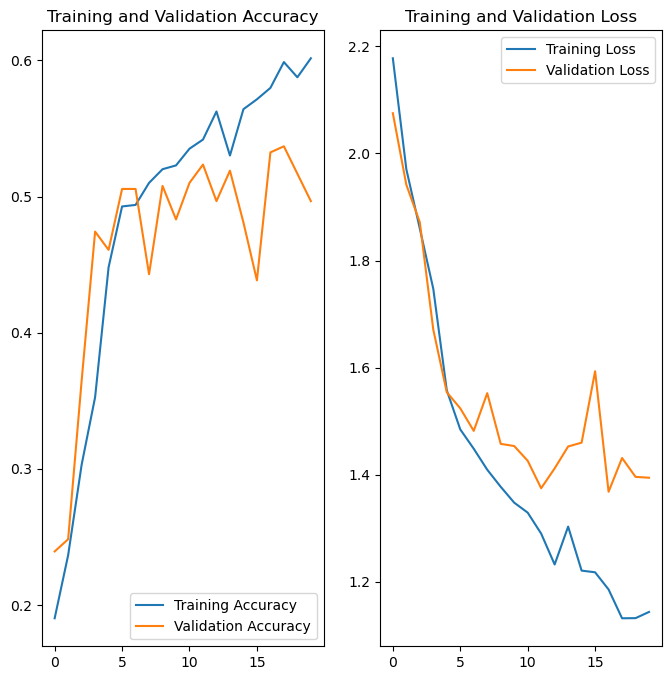

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above result, we could see that the accuracy gap between training and validation improved (gap smaller). That means dropout helped the CNN to avoid overfitting. However, as we found imbalanced class earlier, we could handle this too to improve the accuracy gap

## Model Development (3rd Iteration)

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Axes: xlabel='contribution_pct', ylabel='class_name'>

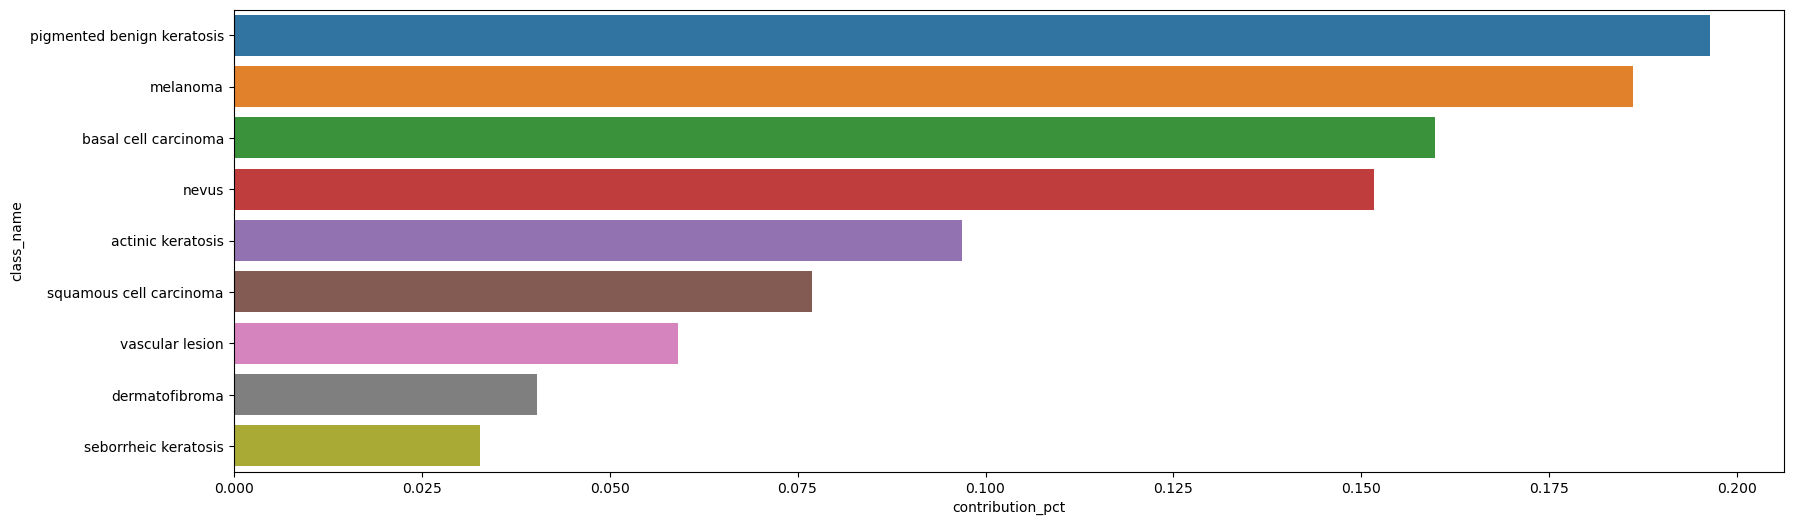

In [28]:
## From below viz, we could see that there was an imbalanced class

import seaborn as sns
plt.figure(figsize=(20, 6))
sns.barplot(x="contribution_pct", y="class_name", data=new_dat)

From below viz, we could see that there was an imbalanced class. Pigmented Benign Keratosis and Melanoma are the highest

**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE734E32730>: 100%|██████████| 500/500 [00:04<00:00, 113.90 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE734C07310>: 100%|██████████| 500/500 [00:04<00:00, 102.68 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE73681A940>: 100%|██████████| 500/500 [00:04<00:00, 104.27 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FE737EA1C70>: 100%|██████████| 500/500 [00:24<00:00, 20.58 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FE734EA3550>: 100%|██████████| 500/500 [00:29<00:00, 16.91 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE734ED5AF0>: 100%|██████████| 500/500 [00:06<00:00, 74.85 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE74ABC6160>: 100%|██████████| 500/500 [00:14<00:00, 34.24 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE734E5F730>: 100%|██████████| 500/500 [00:05<00:00, 85.82 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /Users/prampras/Desktop/My_Desktop/ST/Upgrad_AI_ML_Miscellaneous/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE73ABDEA60>: 100%|██████████| 500/500 [00:05<00:00, 84.93 Samples/s]


By having this augmentor, we could increase the rows or samples so that we would have more data points.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [33]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [34]:

val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [35]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())


#Dense Layer
model.add(layers.Dense(64,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                  

### Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train your model

In [37]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30


169/169 [==============================] - 72s 419ms/step - loss: 2.1983 - accuracy: 0.1434 - val_loss: 2.1606 - val_accuracy: 0.1752
Epoch 2/30
169/169 [==============================] - 76s 448ms/step - loss: 2.1050 - accuracy: 0.1866 - val_loss: 2.1135 - val_accuracy: 0.2116
Epoch 3/30
169/169 [==============================] - 72s 422ms/step - loss: 2.0259 - accuracy: 0.2214 - val_loss: 1.9849 - val_accuracy: 0.2339
Epoch 4/30
169/169 [==============================] - 72s 420ms/step - loss: 1.9541 - accuracy: 0.2341 - val_loss: 1.9155 - val_accuracy: 0.2249
Epoch 5/30
169/169 [==============================] - 70s 411ms/step - loss: 1.8894 - accuracy: 0.2387 - val_loss: 1.9535 - val_accuracy: 0.2212
Epoch 6/30
169/169 [==============================] - 69s 404ms/step - loss: 1.8353 - accuracy: 0.2778 - val_loss: 1.7986 - val_accuracy: 0.3482
Epoch 7/30
169/169 [==============================] - 69s 405ms/step - loss: 1.7210 - accuracy: 0.3275 - val_loss: 1.6903 - val_accuracy: 0.3

###  Visualize the model results

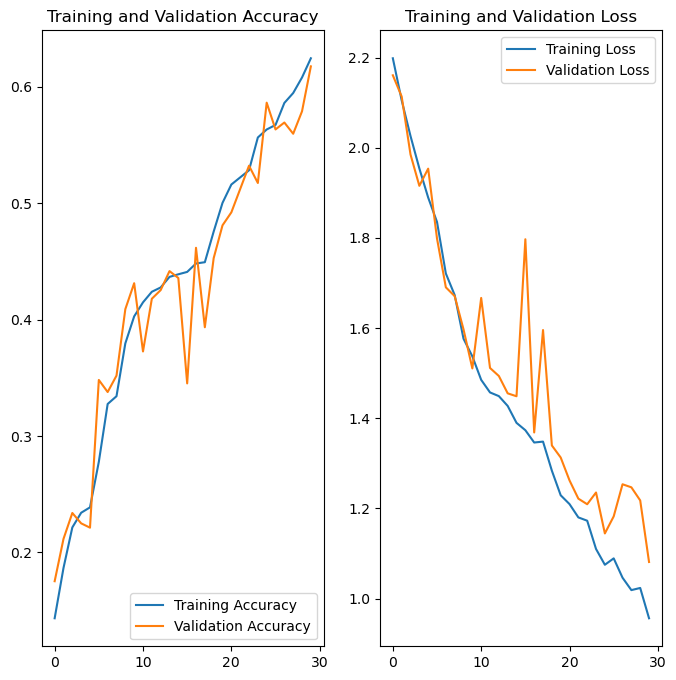

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After we implemented augmentor, now we had smaller gap of accuracy between validation and training, with a high accuracy as well for both of them

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced but it reduced the Acurracy.